In [ ]:
"""
11주차 실습: 의료영상 분석 (중고급)
Advanced Medical Image Analysis with Chest X-Ray

데이터셋: Kaggle Chest X-Ray Pneumonia Dataset
목표: 고급 Transfer Learning + 성능 최적화 + 심화 XAI

실습 구성:
1. 환경 설정 및 유틸리티 함수
2. DICOM 고급 분석
3. 데이터셋 준비 (Train/Val/Test 분리)
4. 고급 데이터 증강 및 전처리
5. ResNet18 모델 + Early Stopping + LR Scheduler
6. 학습 및 검증
7. 심화 평가 (ROC-AUC, Precision-Recall)
8. 고급 Grad-CAM 분석 및 비교
9. 모델 저장 및 성능 보고서
"""

'\n11주차 실습: 의료영상 분석 (중고급)\nAdvanced Medical Image Analysis with Chest X-Ray\n\n데이터셋: Kaggle Chest X-Ray Pneumonia Dataset\n목표: 고급 Transfer Learning + 성능 최적화 + 심화 XAI\n\n실습 구성:\n1. 환경 설정 및 유틸리티 함수\n2. DICOM 고급 분석\n3. 데이터셋 준비 (Train/Val/Test 분리)\n4. 고급 데이터 증강 및 전처리\n5. ResNet18 모델 + Early Stopping + LR Scheduler\n6. 학습 및 검증\n7. 심화 평가 (ROC-AUC, Precision-Recall)\n8. 고급 Grad-CAM 분석 및 비교\n9. 모델 저장 및 성능 보고서\n'

In [ ]:
## Kaggle API Token 업로드 코드

from google.colab import files

# 파일 업로드 대화 상자를 띄웁니다.
print("Kaggle API Token (kaggle.json) 파일을 선택하여 업로드해주세요.")
uploaded = files.upload()

# 업로드된 파일 이름을 확인합니다.
if 'kaggle.json' in uploaded:
    print("'kaggle.json' 파일 업로드 완료.")

    # .kaggle 디렉토리를 생성하고 kaggle.json을 이동/복사합니다.
    # Kaggle CLI가 파일을 찾을 수 있도록 표준 위치에 저장합니다.
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/

    # API 키 파일에 대한 권한을 설정합니다 (보안을 위해 필수).
    !chmod 600 ~/.kaggle/kaggle.json

    print("Kaggle 환경 설정 완료. 이제 !kaggle 명령어를 사용할 수 있습니다.")
else:
    print("'kaggle.json' 파일이 업로드되지 않았거나 파일명이 다릅니다.")

Kaggle API Token (kaggle.json) 파일을 선택하여 업로드해주세요.


Saving kaggle.json to kaggle (1).json
'kaggle.json' 파일이 업로드되지 않았거나 파일명이 다릅니다.


In [ ]:
# 섹션 1: 환경 설정 및 고급 라이브러리

# 필요한 라이브러리 설치 (에러 방지를 위해 분리 및 이름 수정)

# pydicom 설치
!pip install -q pydicom
# pytorch-grad-cam 대신 pypi에 등록된 'grad-cam'을 설치하도록 수정
!pip install -q grad-cam opendatasets scikit-plot

In [ ]:
# 기본 라이브러리
import os
import numpy as np
import pandas as pd  # 결과 분석용
import matplotlib.pyplot as plt
from PIL import Image
import time  # 학습 시간 측정
import json  # 설정 저장용
from datetime import datetime  # 타임스탬프

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
# random_split을 사용하기 위해 import
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
# 모델 가중치 로드 시 호환성 문제 해결을 위해 Weights 사용
from torchvision import models
from torchvision.models import ResNet18_Weights

# 평가 지표
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve,
    f1_score, accuracy_score, precision_score,
    recall_score, roc_auc_score, average_precision_score)

import seaborn as sns

In [ ]:
# DICOM 처리
import pydicom

# Grad-CAM (패키지 이름은 'grad-cam'으로 설치했으나, 내부 모듈명은 'pytorch_grad_cam'을 유지)
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [ ]:
# 랜덤 시드 고정 (재현성)
def set_seed(seed=42):
    """모든 난수 생성기의 시드를 고정하는 함수"""
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU
    torch.cuda.manual_seed_all(seed)  # Multi-GPU
    np.random.seed(seed)  # NumPy
    # CuDNN 설정은 모델 학습 속도에 영향을 줄 수 있으나, 재현성을 위해 결정론적 모드를 활성화
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n사용 디바이스: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   CUDA 버전: {torch.version.cuda}")
print(f"   PyTorch 버전: {torch.__version__}")

# 실험 설정 저장용 딕셔너리
experiment_config = {
    'date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'device': str(device),
    'pytorch_version': torch.__version__,
}


사용 디바이스: cuda
   GPU: NVIDIA L4
   CUDA 버전: 12.6
   PyTorch 버전: 2.9.0+cu126


In [ ]:
# # [Bact to the Basic]
# print(datetime.now())
# print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

In [ ]:
# DICOM 고급 분석

def analyze_dicom_metadata(dicom_path):
    return {"Message": "Not a DICOM file in this dataset"}

# DICOM 시각화 함수 (Window Level/Width 적용)
def visualize_dicom_with_windowing(dicom_path, window_center=None, window_width=None):
    """
    DICOM 이미지를 Window Level/Width를 적용하여 시각화
    Args:
        dicom_path: DICOM 파일 경로
        window_center: 윈도우 중심값 (밝기)
        window_width: 윈도우 폭 (대비)
    """
    # 이 데이터셋은 JPEG 파일이므로 실제 DICOM 로직은 실행되지 않음
    return None, {'Message': 'Not a DICOM file in this dataset'}

print("\nDICOM 분석 개념:")
print("   Window Level (밝기): 관심 영역의 중심 값")
# Window Level (밝기): 어디를 중심으로 보지? (보고자 하는 것의 평균 밝기)
# > 밝기 조절 (명도)

print("   Window Width (대비): 표시할 픽셀값 범위")
# Window Width (대비) 얼마나 넓은 범위를 볼 것인가
# contrast 조절 (대비)
# 폭이 좁으면? 명암 대비가 커져요 >> 흑백이 뚜렷해짐 (구조가 비슷한 거 구별 용이)
# 폭이 넓으면? 명암 대비가 부드러워져요 (다양한 조직 한번에 볼 수 있어)
print("   → 폐 조직: WL=-600, WW=1500")
print("   → 연조직: WL=40, WW=400")


DICOM 분석 개념:
   Window Level (밝기): 관심 영역의 중심 값
   Window Width (대비): 표시할 픽셀값 범위
   → 폐 조직: WL=-600, WW=1500
   → 연조직: WL=40, WW=400


HU (Housefield Unit) : CT 촬영한 원본 데이터 (-1000~3000)
- 이 4000 정도 범위를 가진 색상을 화면 상에서 보이게 해야 함
- 화면 상 보이는 색상은 0(검정색)부터 255(흰색) 임
- 여기서 문제 발생. HU정보(4000개)를 256개의 색상으로 표현해야 함
- 다 보여 줄 수 없으니깐 일부만 잘라서 보여줘야 함. 그 자른 범위의 크기가 바로 Window Width(WW) 임.
- 폭이 작다는 의미는 예로 들어 HU를 50-100 까지 설정하면 조금만 바뀌여도 아주 작은 차이만 있어도 색이 심하게 변함
- 검정색-흰색의 변화가 급발진 > 대비(contrast) 가 크다
- 비슷비슷하게 생긴 즉 구조가 비슷한 간이나 종양 미세한 차이 구분할 때 유리
- 반대로 폭을 넓게 잡으면 예를 들어 HU를 -1000~1000 일 경우, 2000개의 범위를 256개에 억지로 구겨 넣는 효과, 따라서 HU가 10, 20, 30 변해도 색깔 변화가 거의 없음
- 색변화가 거의 없고, 즉 대비(contrast) 가 낮고 전체적으로 뿌옇게 보임
- 따라서 뼈(하얀색), 폐(검은색) 처럼 성격이 아주 다른 것 한번에 볼 때 사용

In [ ]:
# 섹션 3: 데이터셋 다운로드 및 준비


# Kaggle 데이터셋 다운로드

# Colab에서 kaggle.json 업로드는 수동으로 이미 했다고 가정하고
# 자동 다운로드 및 압축 해제 코드만 실행
try:
    # Colab에서 files.upload() 대신 셸 명령어로 파일 처리 (사용자 업로드 가정)
    if os.path.exists("kaggle.json"):
        from google.colab import files # files.upload()가 없어도 files 모듈은 import 필요

        !mkdir -p ~/.kaggle
        !cp kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json

        print("\n⏳ 다운로드 중... (약 2-3분 소요)")
        # -p ./data : 다운로드 경로를 ./data로 지정
        !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p ./data
        # -o: 덮어쓰기, -q: 조용히 실행, -d: 압축 해제 경로
        !unzip -o -q ./data/chest-xray-pneumonia.zip -d ./data/

        # 불필요한 파일/폴더 제거
        !rm ./data/chest-xray-pneumonia.zip
        !rm -rf ./data/__MACOSX

        print("다운로드 완료!")
        data_dir = "./data/chest_xray"
    else:
        print("'kaggle.json' 파일이 없습니다. 수동으로 업로드하거나 이전 셀을 확인하세요.")
        data_dir = "./data/chest_xray" # 경로 변수는 설정

except Exception as e:
    print(f"다운로드 실패: {e}")
    data_dir = "./data/chest_xray"

# 데이터 경로 설정 및 유효성 검사
if not os.path.exists(os.path.join(data_dir, 'train')):
    print(f"{data_dir} 경로에 'train' 폴더가 없습니다. 데이터셋 다운로드/경로를 확인하세요.")



⏳ 다운로드 중... (약 2-3분 소요)
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other


In [ ]:
# 데이터셋 통계 분석
def analyze_dataset_distribution(data_dir):
    """데이터셋의 클래스별 분포 분석"""
    stats = {}

    # Kaggle 데이터셋은 train, test, val 폴더로 구성되어 있음
    for split in ['train', 'test', 'val']:
        split_path = os.path.join(data_dir, split)
        if os.path.exists(split_path):
            stats[split] = {}
            for class_name in ['NORMAL', 'PNEUMONIA']:
                class_path = os.path.join(split_path, class_name)
                if os.path.exists(class_path):
                    # 이미지 파일만 카운트
                    count = len([f for f in os.listdir(class_path)
                                if f.lower().endswith(('.jpeg', '.jpg', '.png'))])
                    stats[split][class_name] = count

    return stats

In [ ]:
# 데이터 분포 확인
analyze_dataset_distribution(data_dir)

In [ ]:
dataset_stats = analyze_dataset_distribution(data_dir)

pd.DataFrame(dataset_stats).T
df_stats = pd.DataFrame(dataset_stats).T
df_stats

In [ ]:
# 클래스 불균형 확인
if 'train' in dataset_stats and 'NORMAL' in dataset_stats['train'] and 'PNEUMONIA' in dataset_stats['train']:
    train_normal = dataset_stats['train']['NORMAL']
    train_pneumonia = dataset_stats['train']['PNEUMONIA']
    if train_normal > 0:
        imbalance_ratio = train_pneumonia / train_normal
        print(f"\n클래스 불균형 비율: {imbalance_ratio:.2f}:1 (PNEUMONIA:NORMAL)")
        if imbalance_ratio > 2:
            print("   → 심각한 불균형! 가중치 적용 고려 필요")
    else:
        imbalance_ratio = 0
        print("Train/NORMAL 데이터가 0개입니다.")
else:
    imbalance_ratio = 0
    print("Train 데이터셋 통계를 확인할 수 없습니다. 데이터 경로를 확인하세요.")

In [ ]:
# 섹션 4: 고급 데이터 증강 및 전처리


print("\n고급 증강 기법:")
print("   1. RandomHorizontalFlip: 좌우 반전")
print("   2. RandomRotation: 회전 (±15도)")
print("   3. RandomAffine: 이동 및 스케일링")
print("   4. ColorJitter: 밝기/대비 조정")
print("   5. GaussianBlur: 가우시안 블러 (노이즈 내성)")

# ImageNet의 평균 및 표준편차 (전역 변수로 정의)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Train용 고급 증강
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # 약간 크게 리사이즈
    transforms.RandomCrop((224, 224)),  # 무작위 크롭 (224x224)
    transforms.Grayscale(num_output_channels=3),  # RGB 변환
    transforms.RandomHorizontalFlip(p=0.5),  # 50% 확률 좌우 반전
    transforms.RandomRotation(degrees=15),  # ±15도 회전
    transforms.RandomAffine(
        degrees=0,  # 회전은 위에서 처리
        translate=(0.1, 0.1),  # 10% 범위 이동
        scale=(0.9, 1.1),  # 90%~110% 스케일
    ),
    transforms.ColorJitter(
        brightness=0.2,  # 밝기 ±20%
        contrast=0.2,    # 대비 ±20%
    ),
    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=3)  # 가우시안 블러
    ], p=0.3),  # 30% 확률
    transforms.ToTensor(),  # 텐서 변환
    transforms.Normalize(
        mean=IMAGENET_MEAN,  # ImageNet 평균
        std=IMAGENET_STD    # ImageNet 표준편차
    )
])

# Validation/Test용 전처리 (증강 없음)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 크기만 조정
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=IMAGENET_MEAN,
        std=IMAGENET_STD
    )
])


In [ ]:
# Custom Dataset 클래스 (고급)
class ChestXrayDatasetAdvanced(Dataset):
    """
    고급 흉부 X-Ray 데이터셋 클래스
    - 메타데이터 추출 옵션
    - 클래스 가중치 계산
    """
    def __init__(self, root_dir, transform=None, return_path=False):
        """
        Args:
            root_dir: 데이터 루트 디렉토리
            transform: 전처리 파이프라인
            return_path: 이미지 경로도 함께 반환할지 여부
        """
        self.root_dir = root_dir
        self.transform = transform
        self.return_path = return_path
        self.images = []  # 이미지 경로 리스트
        self.labels = []  # 라벨 리스트

        # 클래스별 이미지 수집
        classes = ['NORMAL', 'PNEUMONIA']
        for label, class_name in enumerate(classes):
            class_dir = os.path.join(root_dir, class_name)
            if os.path.exists(class_dir):
                for img_name in os.listdir(class_dir):
                    # 이미지 파일 확장자 체크
                    if img_name.lower().endswith(('.jpeg', '.jpg', '.png')):
                        img_path = os.path.join(class_dir, img_name)
                        self.images.append(img_path)
                        self.labels.append(label)
            else:
                 # val 폴더는 없어도 됨 (train에서 분리하기 때문)
                 if 'val' not in root_dir:
                    # 경고 대신 메시지 출력
                    pass


        # 클래스 가중치 계산 (불균형 처리용) - 학습 데이터 로드 시에만 필요
        self.class_weights = self._calculate_class_weights()

    def _calculate_class_weights(self):
        """클래스 불균형을 보정하기 위한 가중치 계산"""
        if not self.labels:
            return torch.FloatTensor([1.0, 1.0]) # 데이터가 없으면 기본 가중치

        labels_array = np.array(self.labels)
        # bincount는 0부터 시작하는 정수 배열의 각 값의 출현 횟수를 셈
        class_counts = np.bincount(labels_array)
        total_samples = len(labels_array)
        num_classes = len(class_counts)

        # 역빈도 가중치: W_j = N / (C * N_j)
        # N: 전체 샘플 수, C: 클래스 수, N_j: 클래스 j의 샘플 수
        # 0으로 나누는 오류 방지: 0인 클래스 카운트는 매우 큰 가중치를 가짐
        class_counts = np.where(class_counts == 0, 1, class_counts)
        # class_counts == 0 데이터가 0개 이면 > 1로 바꿔줘(나눗셈 에러 방지)

        weights = total_samples / (num_classes * class_counts)
        return torch.FloatTensor(weights)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        # .convert('RGB')를 사용하여 3채널 이미지로 로드
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        if self.return_path:
            return image, label, img_path
        return image, label

# Dataset 생성
print("\n Dataset 생성 및 분리...")

In [ ]:
# Train 데이터 로드 (validation set 분리 전 전체 train 데이터)
train_full_dataset = ChestXrayDatasetAdvanced(
    root_dir=os.path.join(data_dir, "train"),
    transform=train_transform
)

# Train을 Train/Val로 분리 (80:20)
if len(train_full_dataset) > 0:
    train_size = int(0.8 * len(train_full_dataset))
    val_size = len(train_full_dataset) - train_size
    train_dataset, val_dataset = random_split(
        train_full_dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )
else:
    # 데이터셋 로드 실패 시 빈 데이터셋 생성 (에러 방지)
    train_dataset = []
    val_dataset = []

# Test 데이터 로드
# Note: 이 데이터셋은 이미 test 폴더가 분리되어 있으므로 그대로 사용
test_dataset = ChestXrayDatasetAdvanced(
    root_dir=os.path.join(data_dir, "test"),
    transform=test_transform,
    return_path=True  # Grad-CAM용 경로 필요
)

print(f"   Train: {len(train_dataset)}장")
print(f"   Validation: {len(val_dataset)}장")
print(f"   Test: {len(test_dataset)}장")

# 클래스 가중치 확인 (전체 Train 데이터 기준)
class_weights = train_full_dataset.class_weights
print(f"\n클래스 가중치: {class_weights.tolist()}")

In [ ]:
# DataLoader 생성
batch_size = 32
num_workers = 2 # Colab 환경에 적합한 워커 수

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,  # Train은 섞기
    num_workers=num_workers,
    pin_memory=True  # GPU 전송 속도 향상
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,  # Validation은 섞지 않음
    num_workers=num_workers,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

print(f"\nDataLoader 생성 완료:")
print(f"   Batch size: {batch_size}")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")

experiment_config['batch_size'] = batch_size
experiment_config['train_size'] = len(train_dataset)
experiment_config['val_size'] = len(val_dataset)
experiment_config['test_size'] = len(test_dataset)

In [ ]:
# 데이터셋이 비어있는 경우 학습을 건너뛰는 플래그
is_trainable = len(train_dataset) > 0

if is_trainable:

    # 섹션 5: 모델 구성 + Early Stopping + LR Scheduler

    print("\n" + "=" * 60)
    print("섹션 5: ResNet18 모델 + 고급 학습 기법")
    print("=" * 60)

    # ResNet18 모델 로드
    print("\nResNet18 Transfer Learning 모델 구성:")
    # ResNet18_Weights.IMAGENET1K_V1을 명시적으로 사용하여 최신 버전의 가중치 로드
    # [Image of ResNet18 architecture]
    model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

    # FC layer 교체
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 2)  # 2 클래스
    model = model.to(device)

    print(f"FC layer: {num_features} → 2")
    print(f"모델을 {device}로 이동")

    # 손실 함수 (클래스 가중치 적용)
    # class_weights는 FloatTensor여야 하며, device에 이동시켜야 함
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    print(f"\n가중치 적용된 CrossEntropyLoss 사용")

    # 옵티마이저 (AdamW - Weight Decay 포함)
    optimizer = optim.AdamW(
        model.parameters(),
        lr=0.0001,
        weight_decay=0.01  # L2 정규화
    )
    print(f"옵티마이저: AdamW (lr=0.0001, weight_decay=0.01)")

    # Learning Rate Scheduler (성능 정체 시 LR 감소)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',  # validation loss 기준
        factor=0.5,  # LR을 50%로 감소
        patience=3,  # 3 에폭 동안 개선 없으면 감소

    )
    print(f"LR Scheduler: ReduceLROnPlateau (patience=3)")



    # Early Stopping 클래스
    class EarlyStopping:
        """
        Early Stopping 구현 클래스
        Validation loss가 개선되지 않으면 학습 조기 종료
        """
        def __init__(self, patience=7, min_delta=0.001, verbose=True):
            """
            Args:
                patience: 몇 에폭 동안 개선이 없으면 종료할지
                min_delta: 개선으로 인정할 최소 변화량
                verbose: 로그 출력 여부
            """
            self.patience = patience
            self.min_delta = min_delta
            self.verbose = verbose
            self.counter = 0  # 개선 없는 에폭 카운터
            self.best_loss = None  # 최고 성능
            self.early_stop = False  # 종료 플래그
            self.best_model = None  # 최고 모델 저장

        def __call__(self, val_loss, model):
            """
            Validation loss를 체크하고 Early Stop 여부 결정
            """
            # val_loss가 텐서일 경우 .item()으로 스칼라 값 추출
            if isinstance(val_loss, torch.Tensor):
                val_loss = val_loss.item()

            if self.best_loss is None:
                # 첫 에폭
                self.best_loss = val_loss
                self.save_checkpoint(model)
            elif val_loss > self.best_loss - self.min_delta:
                # 개선되지 않음 (best_loss보다 min_delta만큼 작아지지 않음)
                self.counter += 1
                if self.verbose:
                    print(f"   EarlyStopping counter: {self.counter}/{self.patience}")
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                # 개선됨 (val_loss < self.best_loss - self.min_delta)
                if self.verbose:
                    print(f"Val loss 개선: {self.best_loss:.4f} → {val_loss:.4f}")
                self.best_loss = val_loss
                self.save_checkpoint(model)
                self.counter = 0

        def save_checkpoint(self, model):
            """최고 성능 모델 저장"""
            # 모델의 상태만 저장
            self.best_model = model.state_dict().copy()

    early_stopping = EarlyStopping(patience=5, verbose=True)
    print(f"Early Stopping: patience=5")

    experiment_config['optimizer'] = 'AdamW'
    experiment_config['learning_rate'] = 0.0001
    experiment_config['weight_decay'] = 0.01
    experiment_config['scheduler'] = 'ReduceLROnPlateau'
    experiment_config['early_stopping_patience'] = 5

    # 섹션 6: 학습 및 검증 (고급)

    print("\n" + "=" * 60)
    print("섹션 6: 모델 학습 (Validation + Early Stopping)")
    print("=" * 60)

    # 학습 함수 (Validation 포함)
    def train_and_validate(model, train_loader, val_loader, criterion,
                           optimizer, scheduler, early_stopping, num_epochs=20):
        """
        학습 및 검증 함수 (고급)
        """
        history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': [],
            'learning_rates': []
        }

        best_val_acc = 0.0
        start_time = time.time()

        for epoch in range(num_epochs):
            if early_stopping.early_stop:
                break

            epoch_start = time.time()
            print(f"\n{'='*60}")
            print(f"Epoch [{epoch+1}/{num_epochs}]")
            print(f"{'='*60}")

            # ===== 학습 단계 =====
            model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0

            for batch_idx, (images, labels) in enumerate(train_loader):
                images = images.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # 통계
                # loss.item()을 사용하여 평균 손실 계산
                train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()

                # 진행상황 출력 (100 배치마다)
                if (batch_idx + 1) % 100 == 0: # 데이터셋이 크므로 100 배치마다 출력
                    print(f"   [Train] Batch [{batch_idx+1}/{len(train_loader)}] "
                          f"Loss: {loss.item():.4f}")

            # 에폭 통계
            avg_train_loss = train_loss / len(train_loader)
            train_accuracy = 100 * train_correct / train_total

            # ===== 검증 단계 =====
            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for batch in val_loader:
                    # random_split으로 분리된 dataset은 경로를 반환하지 않으므로 (images, labels) 형태
                    images, labels = batch

                    images = images.to(device)
                    labels = labels.to(device)

                    outputs = model(images)
                    loss = criterion(outputs, labels)

                    val_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()

            avg_val_loss = val_loss / len(val_loader)
            val_accuracy = 100 * val_correct / val_total

            # 이력 저장
            history['train_loss'].append(avg_train_loss)
            history['train_acc'].append(train_accuracy)
            history['val_loss'].append(avg_val_loss)
            history['val_acc'].append(val_accuracy)
            history['learning_rates'].append(optimizer.param_groups[0]['lr'])

            # 에폭 결과 출력
            epoch_time = time.time() - epoch_start
            print(f"\n{'─'*60}")
            print(f"Epoch [{epoch+1}/{num_epochs}] 결과 (소요시간: {epoch_time:.1f}초)")
            print(f"   Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}%")
            print(f"   Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")
            print(f"   Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

            # 최고 성능 체크
            if val_accuracy > best_val_acc:
                best_val_acc = val_accuracy
                print(f"새로운 최고 Val Acc: {best_val_acc:.2f}%")

            # LR Scheduler 업데이트
            scheduler.step(avg_val_loss)

            # Early Stopping 체크
            early_stopping(avg_val_loss, model)

        # 최고 모델 복원
        if early_stopping.best_model is not None:
            model.load_state_dict(early_stopping.best_model)
            print(f"\n최고 성능 모델 복원 완료")

        total_time = time.time() - start_time
        print(f"\n학습 완료! (총 소요시간: {total_time/60:.1f}분)")
        print(f"   최고 Val Acc: {best_val_acc:.2f}%")

        return history
    # 학습 실행
    print("\n학습 시작!\n")
    num_epochs = 20  # 최대 20 에폭 (Early Stopping으로 조기 종료 가능)
    history = train_and_validate(
        model, train_loader, val_loader, criterion,
        optimizer, scheduler, early_stopping, num_epochs
    )

    experiment_config['actual_epochs'] = len(history['train_loss'])
    experiment_config['best_val_accuracy'] = max(history['val_acc']) if history['val_acc'] else 0.0

    # 학습 곡선 시각화 (4개 그래프)
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    epochs_range = range(1, len(history['train_loss']) + 1)

    # Loss 곡선
    axes[0, 0].plot(epochs_range, history['train_loss'], 'b-o', label='Train Loss', linewidth=2)
    axes[0, 0].plot(epochs_range, history['val_loss'], 'r-o', label='Val Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch', fontsize=12)
    axes[0, 0].set_ylabel('Loss', fontsize=12)
    axes[0, 0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Accuracy 곡선
    axes[0, 1].plot(epochs_range, history['train_acc'], 'b-o', label='Train Acc', linewidth=2)
    axes[0, 1].plot(epochs_range, history['val_acc'], 'r-o', label='Val Acc', linewidth=2)
    axes[0, 1].set_xlabel('Epoch', fontsize=12)
    axes[0, 1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[0, 1].set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Learning Rate 변화
    axes[1, 0].plot(epochs_range, history['learning_rates'], 'g-o', linewidth=2)
    axes[1, 0].set_xlabel('Epoch', fontsize=12)
    axes[1, 0].set_ylabel('Learning Rate', fontsize=12)
    axes[1, 0].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_yscale('log')  # 로그 스케일

    # Overfitting 분석
    gap = np.array(history['train_acc']) - np.array(history['val_acc'])
    axes[1, 1].plot(epochs_range, gap, 'purple', linewidth=2)
    axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1, 1].fill_between(epochs_range, gap, 0, where=(gap>0), alpha=0.3, color='red', label='Overfitting')
    # where= (gap > 0) gap 이 0 보다 클경우
    axes[1, 1].set_xlabel('Epoch', fontsize=12)
    axes[1, 1].set_ylabel('Accuracy Gap (%)', fontsize=12)
    axes[1, 1].set_title('Overfitting Analysis (Train - Val)', fontsize=14, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('advanced_training_curves.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\n학습 곡선 저장: advanced_training_curves.png")

else:
    print("\n학습 데이터가 0개이므로 학습 및 모델 관련 섹션을 건너뜁니다.")
    # 임시 history, model, metrics 설정
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'learning_rates': []}
    model = nn.Linear(1, 1).to(device)
    accuracy, f1, roc_auc, pr_auc = 0.0, 0.0, 0.0, 0.0
    experiment_config['actual_epochs'] = 0
    experiment_config['best_val_accuracy'] = 0.0


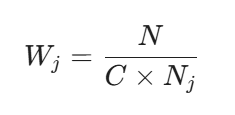

In [ ]:
# Inverse Frequency Class Weighing
# 데이터 불균형 (현재 상황) 클래스 불균형
# 정상인 보다 폐렴에 시달리는 환자가 거의 3배 많은 데이터
# >> 가중치로 조정
# >> 데이터가 적은 클래스 >> 가중치 높게 (중요하니깐)
# >> 데이터가 많은 클래스 >> 가중치 낮게 (덜 중요하니깐)
# N: 전체 데이터 개수 (total samples)
# C: 클래스 (여기서 2개, 정상, 폐렴환자)
# N_j : 특정 클래스(j) 데이터 개수 : 정상 폐 데이터, 폐렴환자 폐 데이터

# 예) 전체 100명, 클래스 2(정상, 폐렴)
# 정상(10명) 폐렴환자(90명)
# 정상 100 / (2*10) = 5 (W_정상)
# 폐렴환자 100 / (2*90) = 0.55 (W_폐렴)

# 전처리 순서
# 데이터셋 로드 >> 가중치 계산 (클래스 불균형 고려, 역빈도 계산 후) >> random split
# >> (batch_size) 결정 한 후, 데이터로더 >> (**) 학습할 때 loss 함수에 가중치 주입하세요
# 역빈도 적용은 희긔해서 중요도가 높은 데이터 (소수 클래스) 손실함수에 가중치(penalty) 부여

In [ ]:
# 섹션 7: 심화 평가 (ROC-AUC, Precision-Recall)

# 평가 함수 (확률값 포함)
def evaluate_model_advanced(model, test_loader):
    """
    고급 평가 함수 - 확률값 및 상세 메트릭 반환
    """
    model.eval()
    all_labels = []
    all_predictions = []
    all_probabilities = []  # 확률값 저장

    with torch.no_grad():
        for batch in test_loader:
            # test_dataset은 return_path=True이므로 3개의 요소 반환
            # images, labels, img_path
            images, labels, _ = batch

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)  # 확률로 변환
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    return (np.array(all_labels),
            np.array(all_predictions),
            np.array(all_probabilities))

if is_trainable and len(test_dataset) > 0:
    # 평가 실행
    print("\n테스트 데이터 평가 중...")
    true_labels, pred_labels, pred_probs = evaluate_model_advanced(model, test_loader)

    # 기본 메트릭
    accuracy = accuracy_score(true_labels, pred_labels) * 100
    f1 = f1_score(true_labels, pred_labels, average='weighted', zero_division=0)

    print(f"\n테스트 성능:")
    print(f"   Accuracy: {accuracy:.2f}%")
    print(f"   F1-Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(true_labels, pred_labels)
    print(f"\nConfusion Matrix:")
    print(cm)

    # Confusion Matrix 시각화
    # [Image of Confusion Matrix example]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['NORMAL', 'PNEUMONIA'],
                yticklabels=['NORMAL', 'PNEUMONIA'],
                cbar_kws={'label': 'Count'})
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('advanced_confusion_matrix.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Classification Report
    print(f"\nClassification Report:")
    print(classification_report(true_labels, pred_labels,
                              target_names=['NORMAL', 'PNEUMONIA'], zero_division=0))

    # ROC Curve 및 AUC
    fpr, tpr, thresholds = roc_curve(true_labels, pred_probs[:, 1])
    # pred_probs[:, 1] ":" 데이터는 다 가져와, 1번(폐렴/양성)일 확률만 사용
    roc_auc = auc(fpr, tpr)

    print(f"\nROC-AUC Score: {roc_auc:.4f}")

    # Precision-Recall Curve
    # >> 데이터불균형 심할 때 (P-R 반비례 관례 Trade-off 관계여서)
    # >> 그래프 어떻게 봐요? 면적이 클수록 좋아요 (우측 상단에 붙을 수록)
    precision, recall, pr_thresholds = precision_recall_curve(true_labels, pred_probs[:, 1])
    pr_auc = auc(recall, precision)

    print(f"PR-AUC Score: {pr_auc:.4f}")

    # ROC & PR Curve 시각화
    # [Image of ROC Curve and Precision-Recall Curve example]
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # ROC Curve
    axes[0].plot(fpr, tpr, color='darkorange', lw=2,
                label=f'ROC Curve (AUC = {roc_auc:.4f})')
    axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlabel('False Positive Rate', fontsize=12)
    axes[0].set_ylabel('True Positive Rate', fontsize=12)
    axes[0].set_title('ROC Curve', fontsize=14, fontweight='bold')
    axes[0].legend(loc="lower right")
    axes[0].grid(True, alpha=0.3)

    # Precision-Recall Curve
    axes[1].plot(recall, precision, color='blue', lw=2,
                label=f'PR Curve (AUC = {pr_auc:.4f})')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('Recall', fontsize=12)
    axes[1].set_ylabel('Precision', fontsize=12)
    axes[1].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
    axes[1].legend(loc="lower left")
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('roc_pr_curves.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\nROC & PR Curves 저장: roc_pr_curves.png")

    experiment_config['test_accuracy'] = float(accuracy)
    experiment_config['f1_score'] = float(f1)
    experiment_config['roc_auc'] = float(roc_auc)
    experiment_config['pr_auc'] = float(pr_auc)

else:
    print("\n학습이 불가능하거나 테스트 데이터셋이 비어있어 평가를 건너뜁니다.")
    experiment_config['test_accuracy'] = 0.0
    experiment_config['f1_score'] = 0.0
    experiment_config['roc_auc'] = 0.0
    experiment_config['pr_auc'] = 0.0

In [ ]:
# 섹션 8: 고급 Grad-CAM 분석

# 학습이 정상적으로 완료되고 테스트 데이터가 있는 경우에만 CAM 분석 수행
if is_trainable and len(test_dataset) > 0:

    print("\n고급 CAM 기법:")
    print("   1. Grad-CAM: 기본 CAM")
    print("   2. Grad-CAM++: 개선된 가중치")
    print("   3. Score-CAM: 기울기 없이 활성화만 사용")

    # 다양한 CAM 기법 준비
    target_layers = [model.layer4[-1]]
    grad_cam = GradCAM(model=model, target_layers=target_layers)
    grad_cam_plus = GradCAMPlusPlus(model=model, target_layers=target_layers)
    score_cam = ScoreCAM(model=model, target_layers=target_layers)

    cam_methods = {
        'Grad-CAM': grad_cam,
        'Grad-CAM++': grad_cam_plus,
        'Score-CAM': score_cam
    }

    # 샘플 이미지 선택 (클래스별 2개씩)
    def get_sample_images_advanced(test_dataset, num_per_class=2):
        """각 클래스에서 샘플 추출 (경로 포함)"""
        samples = {'NORMAL': [], 'PNEUMONIA': []}

        for idx in range(len(test_dataset)):
            # return_path=True로 설정했으므로 3개의 요소 반환
            img_tensor, label, img_path = test_dataset[idx]
            class_name = 'NORMAL' if label == 0 else 'PNEUMONIA'

            if len(samples[class_name]) < num_per_class:
                # 원본 이미지 로드
                orig_img = Image.open(img_path).convert('RGB')
                samples[class_name].append((img_tensor, label, orig_img, img_path))

            if all(len(v) >= num_per_class for v in samples.values()):
                break

        return samples

    print("\n샘플 이미지 선택 및 CAM 생성 중...")
    sample_images = get_sample_images_advanced(test_dataset, num_per_class=2)

    # CAM 비교 시각화
    for class_name, samples in sample_images.items():
        print(f"\n{class_name} 클래스 분석:")

        for sample_idx, (img_tensor, label, orig_img, img_path) in enumerate(samples):
            # 예측
            model.eval()
            input_tensor = img_tensor.unsqueeze(0).to(device)

            with torch.no_grad():
                output = model(input_tensor)
                pred_prob = torch.softmax(output, dim=1)
                pred_class = torch.argmax(pred_prob, dim=1).item()
                confidence = pred_prob[0][pred_class].item() * 100

            pred_name = 'NORMAL' if pred_class == 0 else 'PNEUMONIA'
            print(f"   샘플 {sample_idx+1}: 예측={pred_name}, 신뢰도={confidence:.1f}%")

            # 원본 이미지 전처리
            orig_img_resized = orig_img.resize((224, 224))
            rgb_img = np.array(orig_img_resized, dtype=np.float32) / 255.0 # 0~1 범위로 정규화

            # 여러 CAM 기법 적용
            fig, axes = plt.subplots(1, 4, figsize=(16, 4))

            # 원본 이미지
            axes[0].imshow(orig_img_resized) # RGB 이미지이므로 cmap='gray' 생략
            axes[0].set_title(f'Original\n{class_name}', fontsize=12, fontweight='bold')
            axes[0].axis('off')

            # 각 CAM 기법
            for idx, (method_name, cam_method) in enumerate(cam_methods.items()):
                targets = [ClassifierOutputTarget(pred_class)]

                try:
                    # cam_method(input_tensor)가 텐서를 반환하므로 [0, :]로 numpy 배열 추출
                    # >> 차원 축소 (1, 244, 244) >> (244,244)
                    grayscale_cam = cam_method(input_tensor=input_tensor, targets=targets)[0, :]

                    # 오버레이
                    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

                    axes[idx+1].imshow(cam_image)
                    axes[idx+1].set_title(f'{method_name}', fontsize=12, fontweight='bold')
                    axes[idx+1].axis('off')
                except Exception as e:
                    print(f"   {method_name} 생성 실패: {e}")
                    axes[idx+1].text(0.5, 0.5, f'{method_name}\nError',
                                   ha='center', va='center')
                    axes[idx+1].axis('off')

            plt.suptitle(f'Prediction: {pred_name} ({confidence:.1f}%)',
                        fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.savefig(f'cam_comparison_{class_name}_{sample_idx+1}.png',
                       dpi=150, bbox_inches='tight')
            plt.show()

    print("\nCAM 비교 결과 저장 완료")
else:
    print("\n학습 또는 테스트 데이터셋이 비어있어 CAM 분석을 건너뜁니다.")

In [ ]:
# 섹션 9: 모델 저장 및 최종 보고서


# 모델 저장 (학습이 정상적으로 완료된 경우에만 저장)
# model.state_dict() 모델의 파라미터(가중치, 편향)
# optimizer.state_dict() 최적화 도구가 가지고 있는 내부 상태값(현재의 모멘텀, lr scheduler)
# experiment_config.json 우리가 처음에 설정했던 하이퍼파라미터들(배치 크기, lr, epochs)
# history : 학습과정에서 기록된 loss, accuracy 변환 리스트
model_save_path = 'best_resnet18_pneumonia.pth'
if is_trainable:
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'config': experiment_config,
        'history': history,
    }, model_save_path)
    print(f"\n모델 저장 완료: {model_save_path}")
else:
    print("\n학습이 진행되지 않아 모델 저장을 건너뜁니다.")

In [ ]:
# 실험 설정 JSON 저장
config_save_path = 'experiment_config.json'
with open(config_save_path, 'w', encoding='utf-8') as f:
    json.dump(experiment_config, f, indent=2, ensure_ascii=False)
print(f"실험 설정 저장: {config_save_path}")

In [ ]:
# 최종 성능 보고서

report = f"""
실험 일시: {experiment_config['date']}
디바이스: {experiment_config['device']}

[데이터셋]
- Train: {experiment_config.get('train_size', 0)}장
- Validation: {experiment_config.get('val_size', 0)}장
- Test: {experiment_config.get('test_size', 0)}장
- 클래스 불균형 비율: {experiment_config.get('class_imbalance_ratio', 0.0):.2f}:1

[모델 설정]
- 모델: ResNet18 Transfer Learning
- 옵티마이저: {experiment_config.get('optimizer', 'N/A')}
- Learning Rate: {experiment_config.get('learning_rate', 'N/A')}
- Batch Size: {experiment_config.get('batch_size', 'N/A')}
- 실제 학습 에폭: {experiment_config.get('actual_epochs', 0)}

[성능]
- Test Accuracy: {experiment_config.get('test_accuracy', 0.0):.2f}%
- F1-Score: {experiment_config.get('f1_score', 0.0):.4f}
- ROC-AUC: {experiment_config.get('roc_auc', 0.0):.4f}
- PR-AUC: {experiment_config.get('pr_auc', 0.0):.4f}
- Best Val Accuracy: {experiment_config.get('best_val_accuracy', 0.0):.2f}%

[생성 파일]
- advanced_training_curves.png
- advanced_confusion_matrix.png
- roc_pr_curves.png
- cam_comparison_*.png
- {model_save_path}
- {config_save_path}
"""

print(report)